# Customer churn prediction model for a telecom company

The company has provided the following customer data up to the current date (February 1, 2020):
- contract information;
- customer personal data;
- internet service information;
- telephone service information.

The work will examine data for individual groups (customers who left/remained), then prepare the data for model training, select models and hyperparameters, and find the best model. The most important features will then be selected.

In [1]:
#!pip install -U -q numpy numba scipy matplotlib==3.7.3 seaborn

In [2]:
# !pip install -U shap -q
# !pip install -U phik -q
# !pip install -U imbalanced-learn -q
# !pip install -U scikit-learn==1.2.2 -q
# !pip install -U xgboost -q

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.model_selection import GridSearchCV

import shap

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

In [4]:
RANDOM_STATE = 20052024
TEST_SIZE = 0.25
DATE = pd.Timestamp('2020-02-01')

## Data Loading

In [5]:
def check_if_colab():
    try:
        if 'COLAB_GPU' in os.environ:
            return True
    except KeyError:
        return False

if check_if_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = '/content/drive/My Drive/ColabNotebooks/Practicum/datasets/'
else:
    root_path = '../datasets/'

In [6]:
PHONE_PATH = root_path + 'phone_new.csv'
PERSONAL_PATH = root_path + 'personal_new.csv'
INTERNET_PATH = root_path + 'internet_new.csv'
CONTRACT_PATH = root_path + 'contract_new.csv'

In [7]:
try:
    phone_df = pd.read_csv(PHONE_PATH, na_values=[' ', np.nan])
    personal_df = pd.read_csv(PERSONAL_PATH, na_values=[' ', np.nan])
    internet_df = pd.read_csv(INTERNET_PATH, na_values=[' ', np.nan])
    contract_df = pd.read_csv(CONTRACT_PATH,
                              dtype={'TotalCharges': 'float64'},
                              na_values=[' ', np.nan],
                              parse_dates=['BeginDate'])
except Exception as e:
    print('path doesn\'t exist')
    print(e)

In [8]:
def df_description(df):
    print('SHAPE: ', df.shape)
    print('DUPLICATES: ', df.duplicated().sum(), '\n')
    df.info()
    display(df.head())
    print('MISSING VALUES:')
    display(pd.DataFrame(round(df.isna().mean()*100,2)).style.background_gradient('coolwarm'))

### Personal_df

In [9]:
df_description(personal_df)

SHAPE:  (7043, 5)
DUPLICATES:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


MISSING VALUES:


,0
customerID,0.000000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000
Dependents,0.000000


In [10]:
personal_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [11]:
for attr in personal_df.columns[1:-1]:
    print(f'{attr}: {personal_df[attr].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']


In [12]:
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
personal_df.sample(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
1043,4883-QICIH,Male,No,Yes,Yes
2599,6384-VMJHP,Female,No,No,No


### Phone_df

In [13]:
df_description(phone_df)

SHAPE:  (6361, 2)
DUPLICATES:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


MISSING VALUES:


,0
customerID,0.000000
MultipleLines,0.000000


In [14]:
print(f"{attr}: {phone_df['MultipleLines'].unique()}")

Partner: ['No' 'Yes']


### Internet_df

In [15]:
df_description(internet_df)

SHAPE:  (5517, 8)
DUPLICATES:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


MISSING VALUES:


,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000


In [16]:
for attr in internet_df.columns[1:-1]:
    print(f'{attr}: {internet_df[attr].unique()}')

InternetService: ['DSL' 'Fiber optic']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']


### Contract_df

In [17]:
df_description(contract_df)

SHAPE:  (7043, 8)
DUPLICATES:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


MISSING VALUES:


,0
customerID,0.000000
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.160000


In [18]:
for attr in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(f'{attr}: {contract_df[attr].unique()}')

Type: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [19]:
contract_df[contract_df.isnull().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


The data contains no duplicates or typos. There are gaps only in the contract data, as there are records of new clients who have not yet made payments as of the current date. For these client, `TotalChrges` will be filled with `0`.

## Data Merging

In [20]:
merged_df = pd.merge(contract_df, personal_df, on='customerID', how='left')
merged_df = pd.merge(merged_df, internet_df, on='customerID', how='left')
merged_df = pd.merge(merged_df, phone_df, on='customerID', how='left')
merged_df.set_index('customerID', inplace=True)
df_description(merged_df)

SHAPE:  (7043, 19)
DUPLICATES:  4 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null 

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


MISSING VALUES:


,0
BeginDate,0.000000
EndDate,0.000000
Type,0.000000
PaperlessBilling,0.000000
PaymentMethod,0.000000
MonthlyCharges,0.000000
TotalCharges,0.160000
gender,0.000000
SeniorCitizen,0.000000
Partner,0.000000


Gaps have appeared, as some clients only use mobile services, while others only use online services. We'll fill these gaps in the pipeline.
In the next step, we'll add a new feature—the number of days a user is using or has used the services.

In [21]:
def calculate_days(row):
    '''
    Calculating the duration of service use (in days)
    '''
    if row['EndDate'] == 'No':
        return (DATE - row['BeginDate']).days
    else:
        return (pd.to_datetime(row['EndDate']) - row['BeginDate']).days

In [22]:
merged_df['DaysUsed'] = merged_df.apply(calculate_days, axis=1)
merged_df.sample(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DaysUsed
customerID,,,,,,,,,,,,,,,,,,,,
5949-HGVJL,2017-12-01,No,Month-to-month,Yes,Electronic check,73.05,1956.28,Female,No,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,No,792
7707-PYBBH,2016-10-01,2018-05-01,Month-to-month,Yes,Mailed check,61.90,1258.43,Male,No,No,No,DSL,Yes,Yes,No,Yes,No,No,No,577
2542-HYGIQ,2020-01-01,No,Month-to-month,No,Credit card (automatic),19.95,19.95,Female,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,31


## Exploratory Data Analysis

Next, we'll work with a copy of the merged dataframe, filling in the gaps to fully explore the data. We'll replace the resulting gaps in the service columns with "Not connected," as the service isn't connected. We'll change the values of the contract expiration column `EndDate` to 'left' or 'current client'.

In [23]:
eda_df = merged_df.copy(deep=True)

In [24]:
def replace_end_date(value):
    try:
        datetime.strptime(value, '%Y-%m-%d')
        return 'left'
    except ValueError:
        return 'current client'

In [25]:
eda_df['EndDate'] = eda_df['EndDate'].apply(replace_end_date)
eda_df['EndDate'].unique()

array(['current client', 'left'], dtype=object)

In [26]:
nan_attr = ['MultipleLines', 'InternetService',	'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
            'TechSupport',	'StreamingTV',	'StreamingMovies']
eda_df[nan_attr] = eda_df[nan_attr].fillna('Not connected')

In [27]:
eda_df.isna().sum()

BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
DaysUsed             0
dtype: int64

In [28]:
def cat_plots(df, columns, group=None):
    if group is None:
        for col in columns:
            counts = df[col].value_counts()
            labels = counts.index.tolist()
            sizes = counts.values.tolist()

            plt.figure(figsize=(4, 4))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.axis('equal')

            plt.title(f'Number of clients by "{col}"\n')
            plt.show()
    else:
        if isinstance(df[group].iloc[0], (int, float)):
            df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
            group = 'subgroup'

        unique_values = df[group].unique()
        labels_target, sizes_target = df[group].value_counts().index.tolist(), df[group].value_counts().values.tolist()
        plt.figure(figsize=(4, 4))
        plt.pie(sizes_target, labels=labels_target, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
        plt.title(f'Number of clients by "{group}""')
        plt.show()

        for col in [col for col in columns if col != group]:
            num_groups = len(unique_values)
            fig, axes = plt.subplots(1, num_groups, figsize=(4 * num_groups, 4))
            fig.suptitle(f'Number of clients by "{col}"')
            plt.subplots_adjust(wspace=0.4, hspace=0.6)

            for ax, value in zip(axes, unique_values):
                subset_df = df[df[group] == value]
                counts = subset_df[col].value_counts()
                labels, sizes = counts.index.tolist(), counts.values.tolist()
                ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
                ax.axis('equal')
                ax.set_title(f'{group}={value}', pad=30)

            plt.show()


def num_plots(df, columns, group=None):
    for col in columns:
        display(df[col].describe())
        plt.figure(figsize=(12, 6))
        if group is None:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')
        else:
            if isinstance(df[group].iloc[0], (int, float)):
                df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
                group = 'subgroup'

            plt.subplot(1, 2, 1)
            sns.boxplot(x=group, y=col, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.histplot(df, x=col, hue=group, kde=True, element='step', stat='density', common_norm=False, alpha=0.5)
            plt.title(f'Distribution of "{col}" by {group}')


        plt.tight_layout()
        plt.show()


def discrete_plots(df, columns, group=None):
    for col in columns:
        plt.figure(figsize=(12, 6))
        if group is None:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, hue=group, data=df)
            plt.title(f'Distribution of "{col}"')
        else:
            if isinstance(df[group].iloc[0], (int, float)):
                df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
                group = 'subgroup'

            plt.subplot(1, 2, 1)
            sns.countplot(x=col, hue=group, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, data=df)
            plt.title(f'Distribution of "{col}"')


        plt.tight_layout()
        plt.show()

In [29]:
eda_df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'DaysUsed'],
      dtype='object')

In [30]:
cat_attr = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',\
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'EndDate',\
       'Type', 'PaperlessBilling', 'PaymentMethod']

num_attr = ['MonthlyCharges', 'TotalCharges', 'DaysUsed']

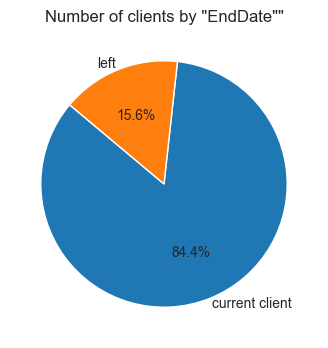

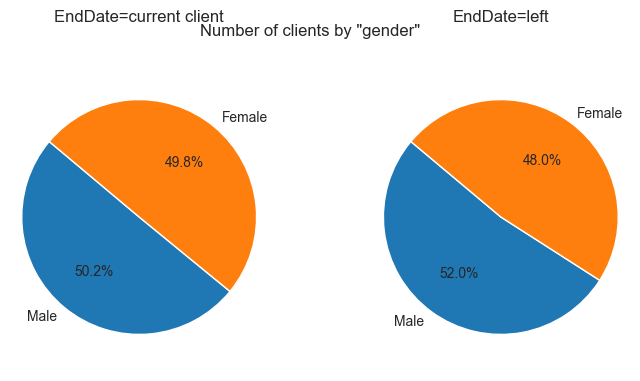

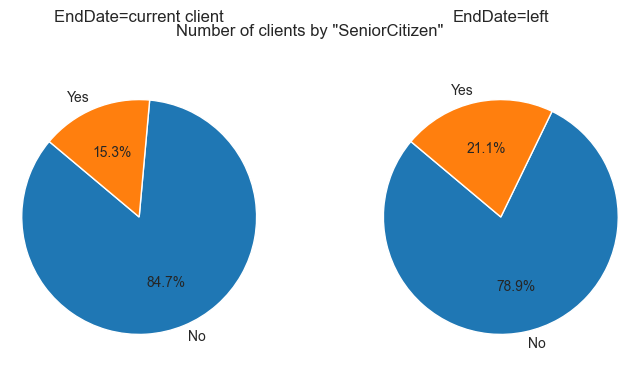

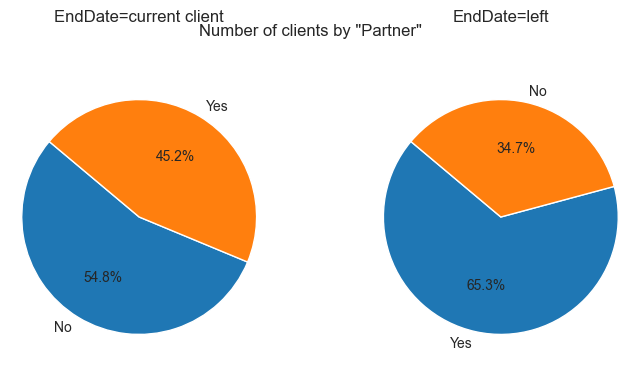

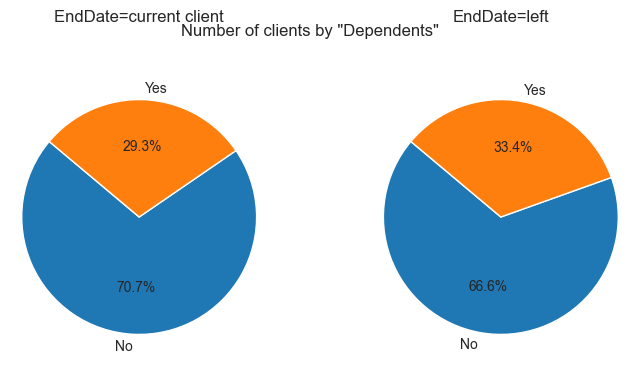

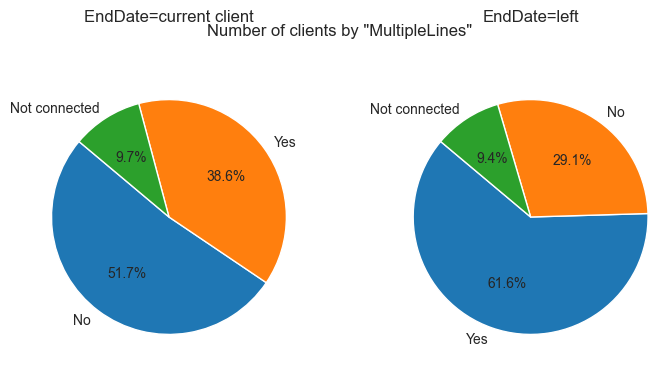

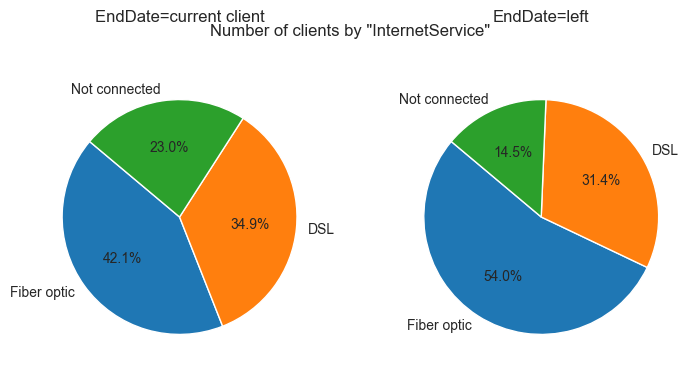

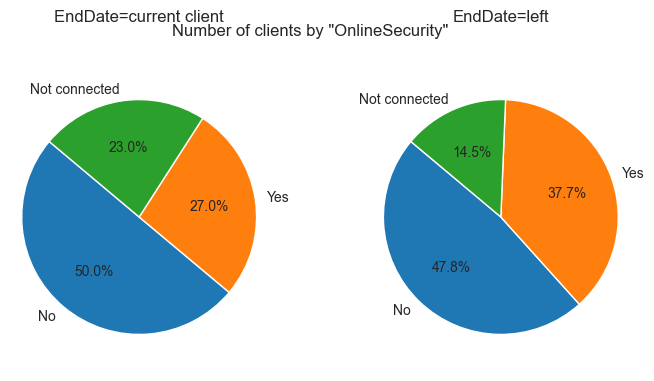

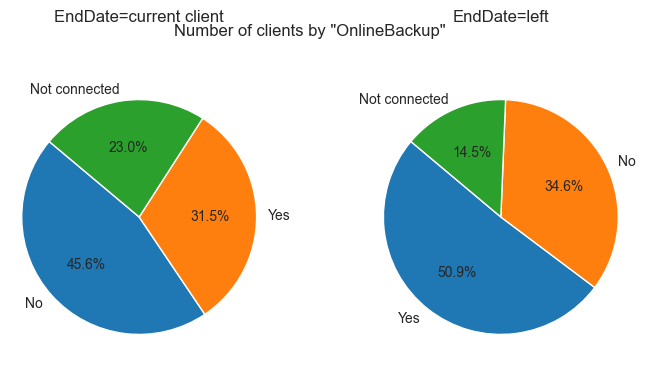

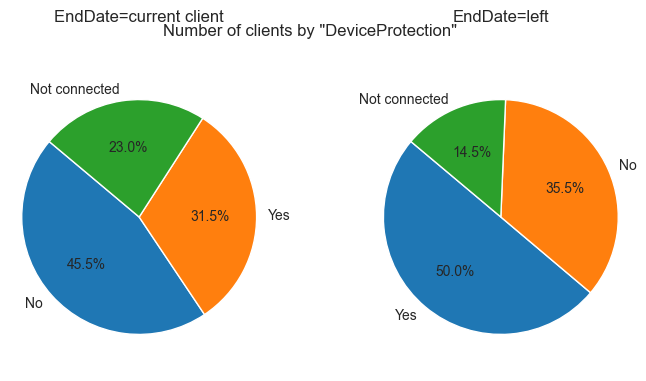

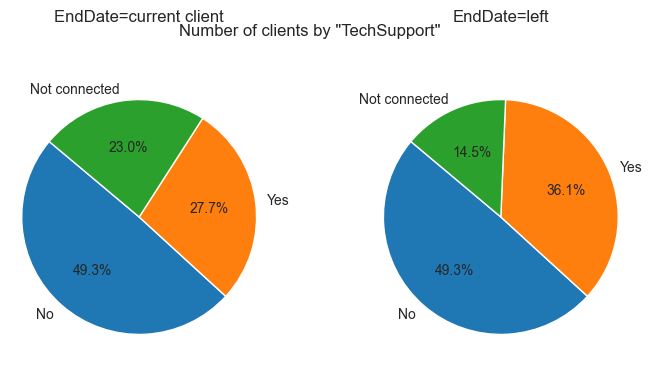

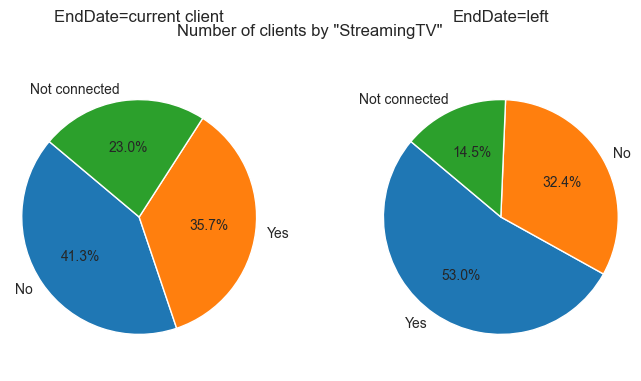

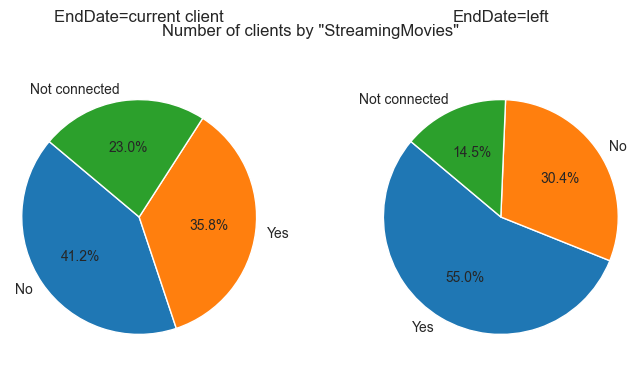

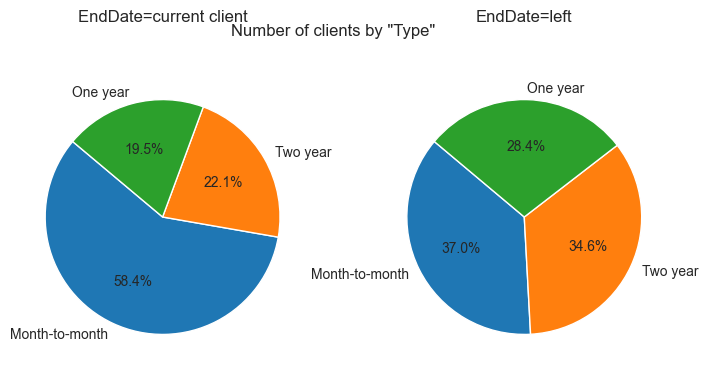

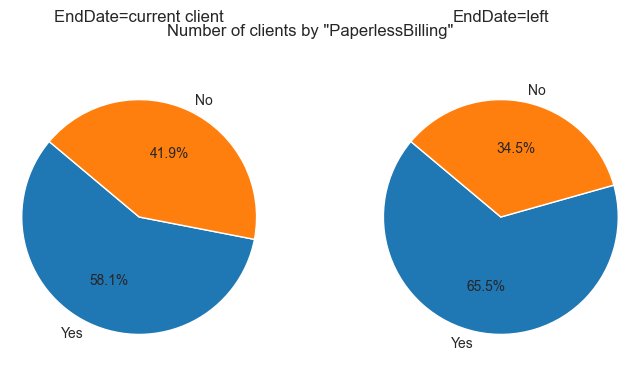

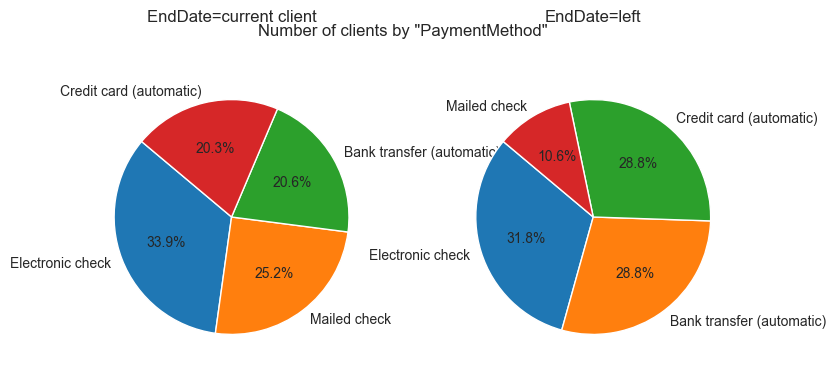

In [31]:
cat_plots(eda_df, cat_attr, group='EndDate')

A strong imbalance in the target variable is evident: only 15% of customers left. The personal data does not reveal significant differences in the proportions of those who left/remained. The most noticeable difference is in the attributes:
- MultipleLines: Most of those who left used multiple phone lines. About half of those who remained use only one line.
- OnlineBackup: Among those who left, roughly the same number used and did not use it. Among those who remained, most do not use it.
- DeviceProtection: Among those who left, roughly the same number used and did not use it. Among those who remained, most do not use it.
- StreamigTV: More than half of those who left used television; more than half of those who remained do not use it.
- StreamingMovies: More than half of those who left used the movie catalog; more than half of those who remained do not use it.
- Type: More than half of those who left use the monthly payment method
- PaymentMethod: There are differences in the proportions of methods, but this is likely due to differences in the number of customers who left/remained

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

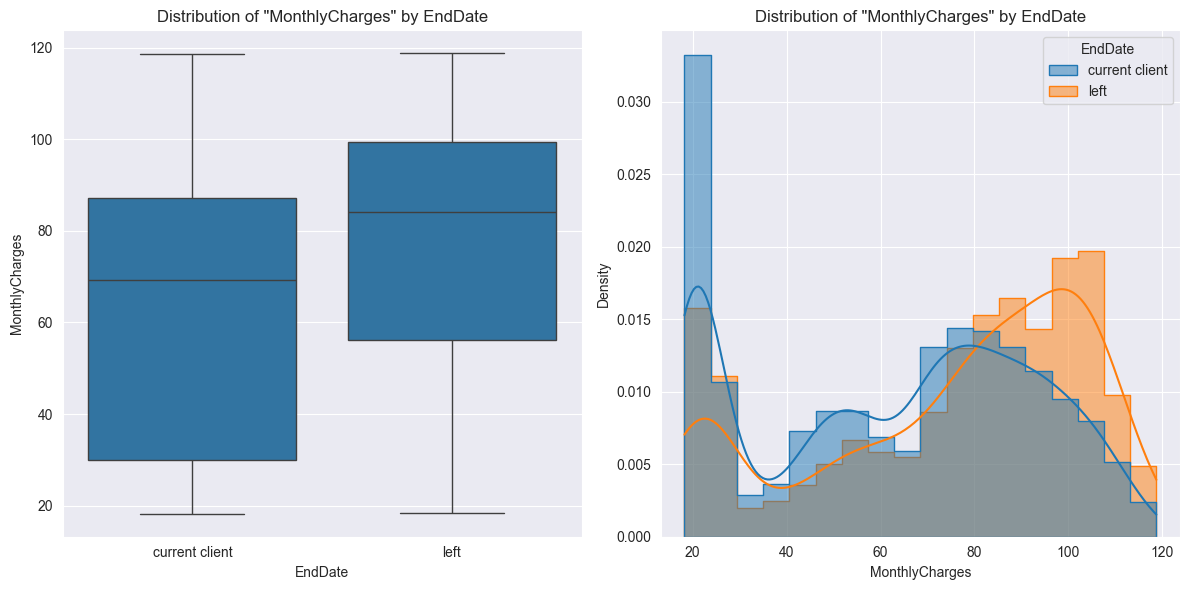

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

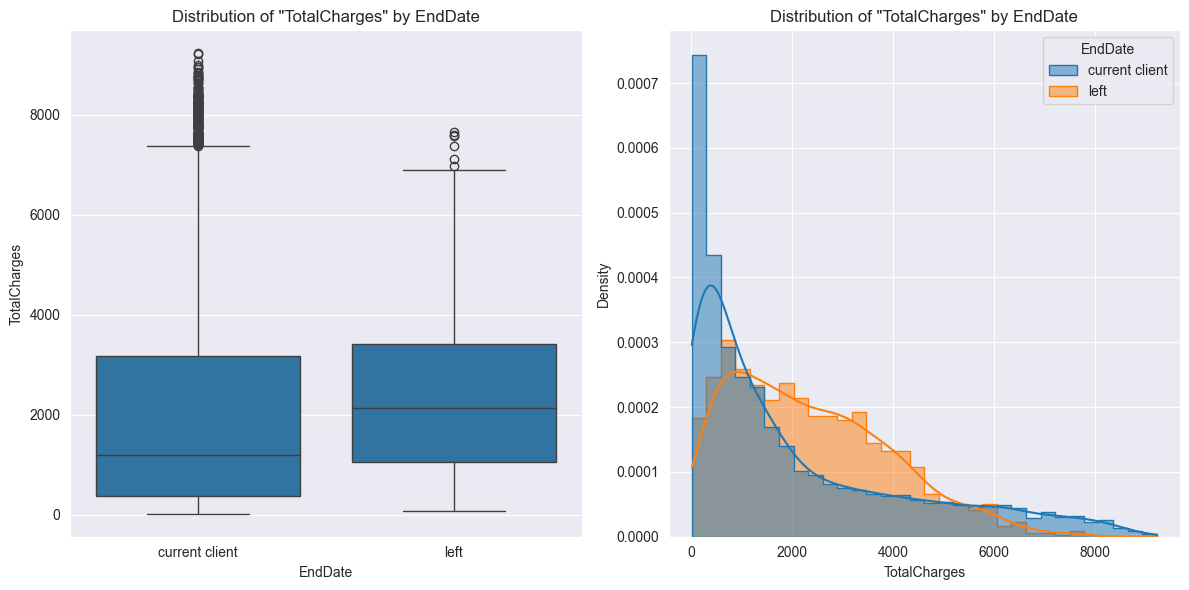

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: DaysUsed, dtype: float64

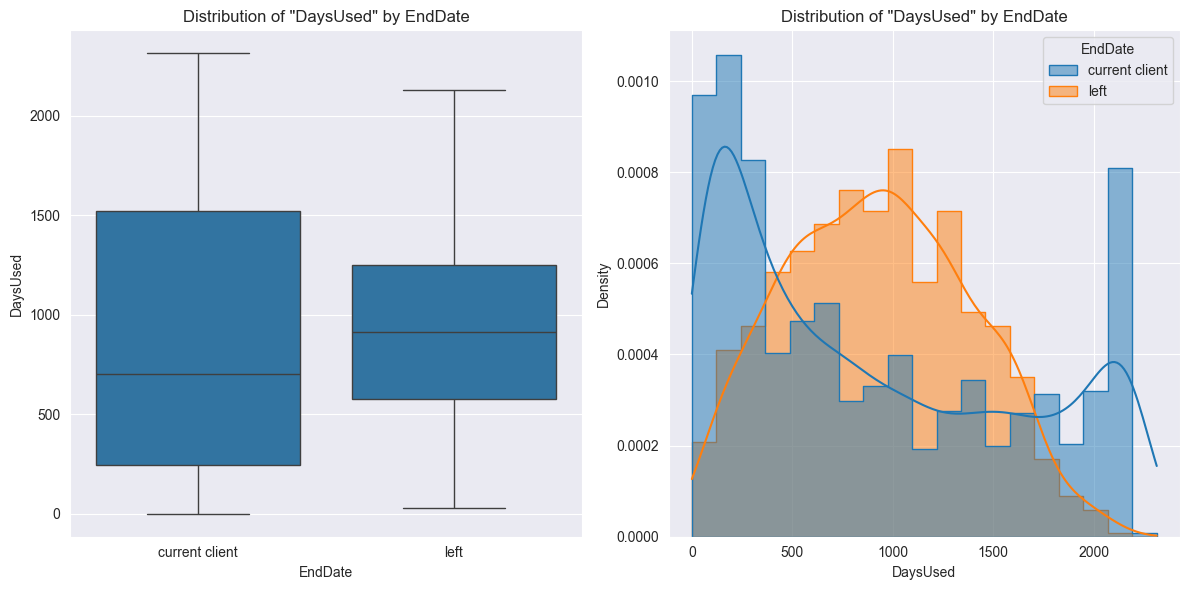

In [32]:
num_plots(eda_df, num_attr, group='EndDate')

- MonthlyCharges: On average, monthly charges for churned customers are higher.
- TotalCharges: On average, values ​​are higher for churned customers, but there are rare high values ​​for those remaining.
- DaysUsed: For those who left, the distribution is more like normal, with an average of around 900-1000 days. Remaining customers are either recent users or long-term users (over 2000 days).

In [33]:
eda_df.drop(columns=['BeginDate'], inplace=True)

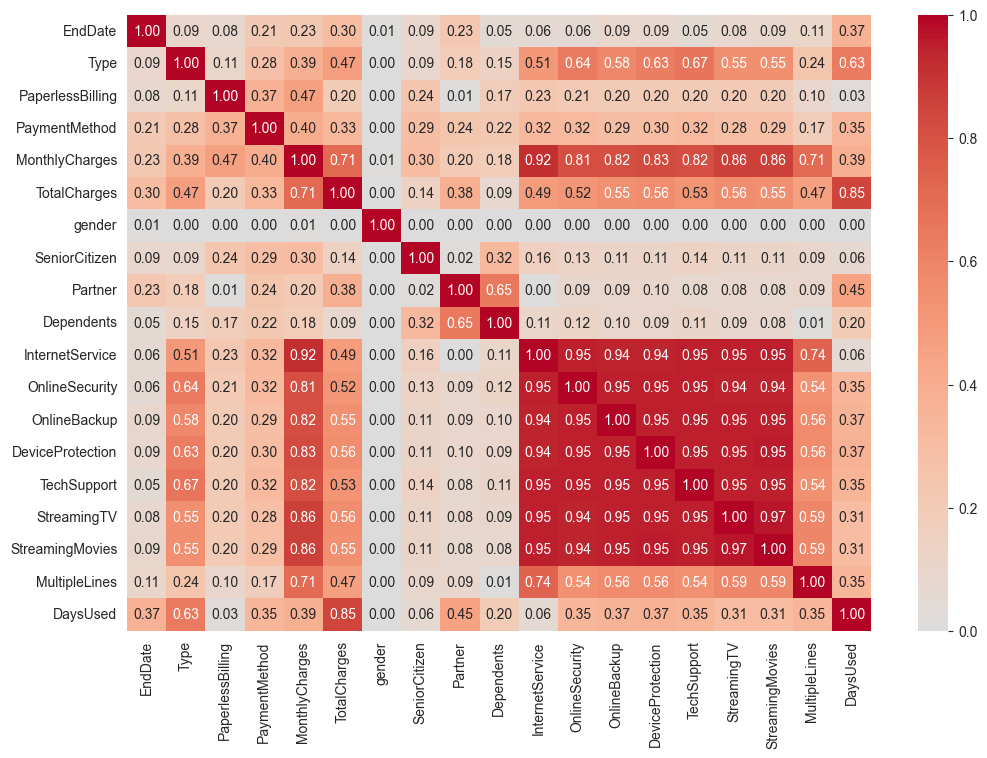

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'DaysUsed']), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

There's a high correlation between different services. However, I suspect it would be inappropriate to remove many attributes at once, as some customers may have left due to poor performance with just one service. We won't include *StreamingMovies* in the training, as there was no visible difference between this attribute and *StreamingTV* during the chart analysis phase.

Also, we shouldn't consider features with very low correlation. These include *gender, Dependents, and TechSupport*. We'll remove these features.
We also consider *InternetService and OnlineSecurity*, but at least some difference was visible for these attributes during the analysis phase, in the pie charts. We'll leave them.

The *TotalCharges* feature is also concerning. The correlation with *DaysUsed* is high, but less than 0.9, so I'm not sure it can be removed. On the other hand, there's *MonthlyCharges*. This means *TotalCharges* can be calculated based on *MonthlyCharges* and *DaysUsed*. I'll leave it at that for now and look at the model's results.

In [35]:
del eda_df

## Model Training

In [36]:
merged_df['EndDate'] = merged_df['EndDate'].apply(replace_end_date)
merged_df['EndDate'].unique()

array(['current client', 'left'], dtype=object)

In [37]:
merged_df.sample()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DaysUsed
customerID,,,,,,,,,,,,,,,,,,,,
4385-ZKVNW,2016-06-01,left,Month-to-month,Yes,Bank transfer (automatic),54.9,1756.8,Male,No,Yes,Yes,DSL,No,Yes,No,Yes,No,No,No,975


In [38]:
X = merged_df.drop(columns=['gender', 'Dependents', 'TechSupport', 'PaperlessBilling', 'StreamingMovies', 'BeginDate', 'EndDate'])
target = merged_df['EndDate']
# apply LabelEncoder to the entire dataset at once to correctly split the data into samples stratified by the target attribute
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
pos_label = 'left'
y = (y_encoded == label_encoder.transform([pos_label])[0]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [39]:
y.mean()

0.15632542950447254

In [40]:
X.columns

Index(['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'SeniorCitizen', 'Partner', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'MultipleLines',
       'DaysUsed'],
      dtype='object')

In [41]:
ohe_columns_service = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', \
                       'DeviceProtection', 'StreamingTV']
ohe_columns = ['SeniorCitizen', 'Partner', 'Type', 'PaymentMethod']
num_columns = ['MonthlyCharges', 'TotalCharges', 'DaysUsed']

### Data Preparation for Linear Models

In [42]:
# a separate pipeline for attribute-connected services, since there is a specific gap-filling strategy here
ohe_service_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Not connected')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
        )
    ]
)

In [43]:
# pipeline for the remaining categorical features.
# There are no missing values in the remaining attributes, but in case there are any in the test data, we'll use most_frequent
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
        )
    ]
)

In [44]:
# if there's a client who hasn't made any payments yet, the missing value is replaces with 0
num_pipe = Pipeline(
    [
        (
            'simpleImputer_before_num_nan',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        ),
        (
            'scaler',
            StandardScaler()
        )
    ]
)

In [45]:
data_preprocessor_linear_models = ColumnTransformer(
    [
        ('ohe_service', ohe_service_pipe, ohe_columns_service),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

The indices from categorical_indices may no longer correspond to the categorical features after the original dataframe passes through the 'preprocessor' step, since the column order may change in the 'preprocessor'. Added `categorical_features=[i for i in range(len(ohe_columns_service + ohe_columns))]` instead of obtaining indices before the pipeline.

In [46]:
final_p_linear_models = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear_models),
        # ('smotenc', SMOTENC(categorical_features=[i for i in range(len(ohe_columns_service + ohe_columns))], sampling_strategy='auto', random_state=RANDOM_STATE)),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

### Data Preparation for Forest Models

In [47]:
ord_service_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Not connected')
        ),
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

In [48]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord_nan',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
)

In [49]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_before_num_nan',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        )
    ]
)

In [50]:
data_preprocessor_tree_models = ColumnTransformer(
    [
        ('ohe_service', ord_service_pipe, ohe_columns_service),
        ('ohe', ord_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [51]:
final_p_tree_models = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree_models),
#         ('smotenc', SMOTENC(categorical_features=[i for i in range(len(ohe_columns_service + ohe_columns))], sampling_strategy='auto', random_state=RANDOM_STATE)),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

In [52]:
def search_model(final_pipeline, parameters, X_train, y_train):
    search = GridSearchCV(
        final_pipeline,
        parameters,
        n_jobs=-1,
        cv=5,
        scoring = 'roc_auc',
        error_score='raise'
    )
    search.fit(X_train, y_train)
    result_df = pd.DataFrame(search.cv_results_)
    print('BEST SCORE: ', search.best_score_)
    return search, result_df

In [53]:
def plot_cv_results(results, title):
    plt.figure(figsize=(10, 6))
    plt.plot(results['mean_test_score'], label='Mean test score')
    plt.fill_between(range(len(results)), 
                     results['mean_test_score'] - results['std_test_score'], 
                     results['mean_test_score'] + results['std_test_score'], 
                     alpha=0.2, label='Std test score')
    plt.xlabel('Experiment')
    plt.ylabel('ROC-AUC Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
param_logreg = [{
    'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')],
    'models__solver': ['lbfgs', 'liblinear'],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
}]

param_random_forest = [    {
    'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
    'models__n_estimators': [50, 100],
    'models__max_depth': range(4, 7),
    'models__max_features': range(2, 5)
}]

param_xgb = [    {
    'models': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)],
    'models__n_estimators': [200, 250, 300],
    'models__max_depth': range(2, 5), 
    'models__scale_pos_weight': [1, np.sum(y == 0) / np.sum(y == 1)]
}]

BEST SCORE:  0.7607295259956455


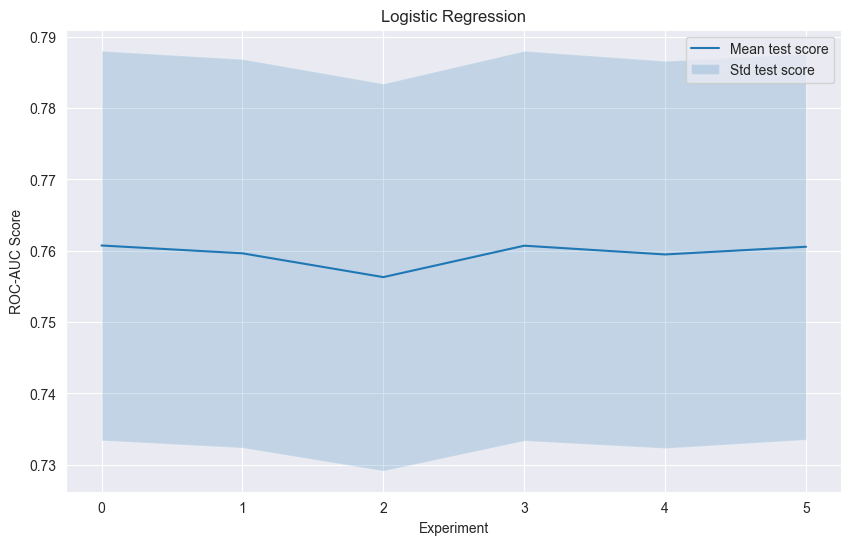

In [55]:
search_logreg, results_logreg = search_model(final_p_linear_models, param_logreg, X_train, y_train)
plot_cv_results(results_logreg, 'Logistic Regression')

BEST SCORE:  0.8217662502860721


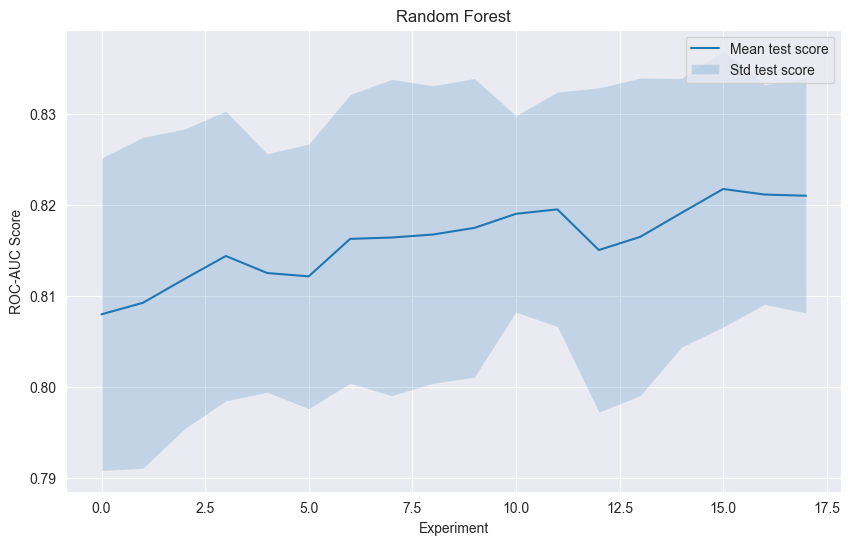

In [56]:
search_random_forest, results_random_forest = search_model(final_p_tree_models, param_random_forest, X_train, y_train)
plot_cv_results(results_random_forest, 'Random Forest')

/Users/arina/GitProjects/machine_learning_projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arina/GitProjects/machine_learning_projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arina/GitProjects/machine_learning_projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/arina/GitProjects/machine_learning_projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: User

BEST SCORE:  0.9129367359469232


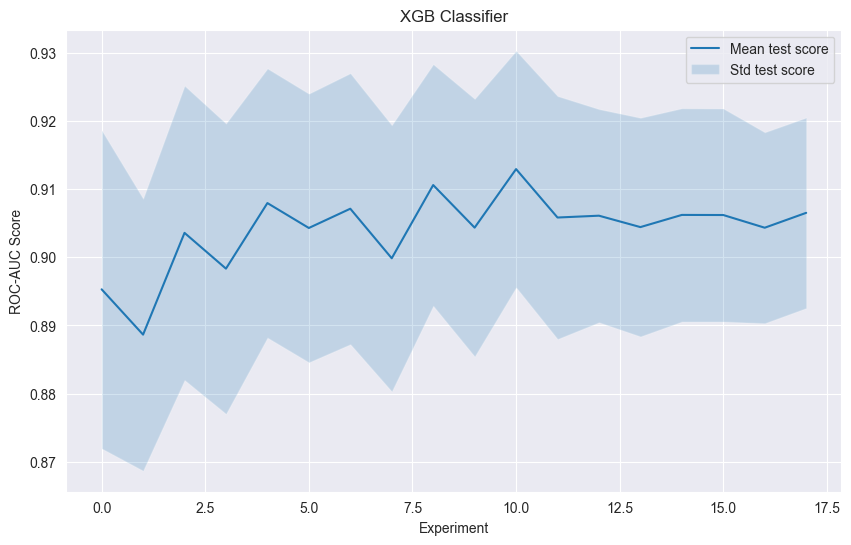

In [57]:
search_xgb, results_xgb = search_model(final_p_tree_models, param_xgb, X_train, y_train)
plot_cv_results(results_xgb, 'XGB Classifier')

The best results were obtained with XGBClassifier, so we will continue working with this model.

In [58]:
print(search_xgb.best_params_, search_xgb.best_score_)

{'models': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...), 'models__max_depth': 3, 'models__n_estimators': 300, 'models__scale_pos_weight': 1} 0.9129367359469232


In [59]:
cv_results = [search_logreg, search_random_forest, search_xgb]

metric_name = 'ROC-AUC'

leaderboard = pd.DataFrame(
    data = {
        'Model': map(lambda x: x.best_estimator_[-1].__class__.__name__, cv_results),
        metric_name: map(lambda x: x.best_score_, cv_results)
    }
)

best_model_index = leaderboard[metric_name].idxmax()
best_cv_result = cv_results[best_model_index]
best_model = best_cv_result.best_estimator_

leaderboard = leaderboard.sort_values(by=metric_name, ascending=False).reset_index(drop=True)

display(leaderboard)

print('Best model architecture:', best_model[-1].__class__.__name__)
print('Hyperparameters:')
print(*[f'{k}: {v}' for k, v in best_cv_result.best_params_.items()], sep='\n')

display(best_model)

,Model,ROC-AUC
0,XGBClassifier,0.912937
1,RandomForestClassifier,0.821766
2,LogisticRegression,0.760730


Best model architecture: XGBClassifier
Hyperparameters:
models: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)
models__max_depth: 3
models__n_estimators: 300
models__scale_pos_weight: 1


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_service',
                                                  Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'connected',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'Onl...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Best model

In [60]:
best_model = search_xgb.best_estimator_

In [61]:
y_pred_prob = best_model.predict_proba(X_test)
y_pred_one = y_pred_prob[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, y_pred_one))

y_pred = best_model.predict(X_test)

ROC-AUC: 0.9219552184020556


In [62]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9267461669505963


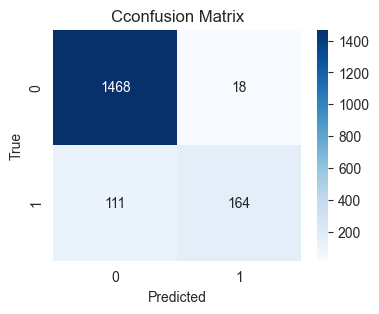

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Сconfusion Matrix')
plt.show()

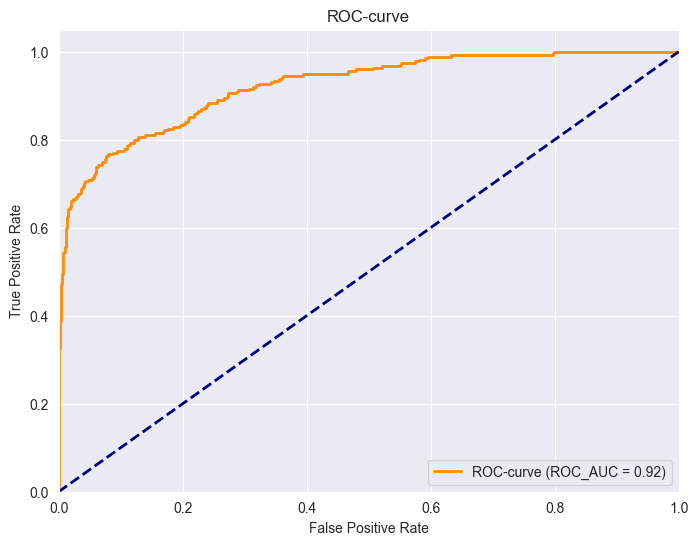

ROC-AUC: 0.9219552184020556


In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_one)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-curve (ROC_AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

print('ROC-AUC:', roc_auc)

The model more often identifies churned customers as retained ones.

## Dummy Classifier

In [65]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)

y_pred_dummy = dummy_classifier.predict(X_test)
print('DummyClassifier:', accuracy_score(y_test, y_pred_dummy))

DummyClassifier: 0.8438387279954571


# Feature Importance

In [66]:
preprocessor = best_model.named_steps['preprocessor']

X_train_2 = preprocessor.transform(X_train)
X_test_2 = preprocessor.transform(X_test)

preprocessor_ohe = preprocessor.named_transformers_['ohe']
ohe_feature_names = preprocessor_ohe.get_feature_names_out(ohe_columns)

preprocessor_ohe_service = preprocessor.named_transformers_['ohe_service']
ohe_service_feature_names = preprocessor_ohe_service.get_feature_names_out(ohe_columns_service)

features = list(ohe_feature_names) + list(ohe_service_feature_names) + num_columns
features

['SeniorCitizen',
 'Partner',
 'Type',
 'PaymentMethod',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'StreamingTV',
 'MonthlyCharges',
 'TotalCharges',
 'DaysUsed']

In [67]:
features_ok = best_model[:-1].get_feature_names_out()
features_ok

array(['ohe_service__MultipleLines', 'ohe_service__InternetService',
       'ohe_service__OnlineSecurity', 'ohe_service__OnlineBackup',
       'ohe_service__DeviceProtection', 'ohe_service__StreamingTV',
       'ohe__SeniorCitizen', 'ohe__Partner', 'ohe__Type',
       'ohe__PaymentMethod', 'num__MonthlyCharges', 'num__TotalCharges',
       'num__DaysUsed'], dtype=object)

In [68]:
X_test_2 = pd.DataFrame(X_test_2, columns=features_ok)
X_test_2.head(2)

,ohe_service__MultipleLines,ohe_service__InternetService,ohe_service__OnlineSecurity,ohe_service__OnlineBackup,ohe_service__DeviceProtection,ohe_service__StreamingTV,ohe__SeniorCitizen,ohe__Partner,ohe__Type,ohe__PaymentMethod,num__MonthlyCharges,num__TotalCharges,num__DaysUsed
0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,100.05,3201.6,975.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,69.35,277.4,123.0


In [69]:
X_shap = best_model['preprocessor'].transform(X_test.sample(200, random_state=RANDOM_STATE))
explainer = shap.Explainer(lambda x: best_model['models'].predict_proba(x)[:,1], shap.maskers.Independent(X_shap), feature_names=features_ok)
shap_values = explainer(X_shap)

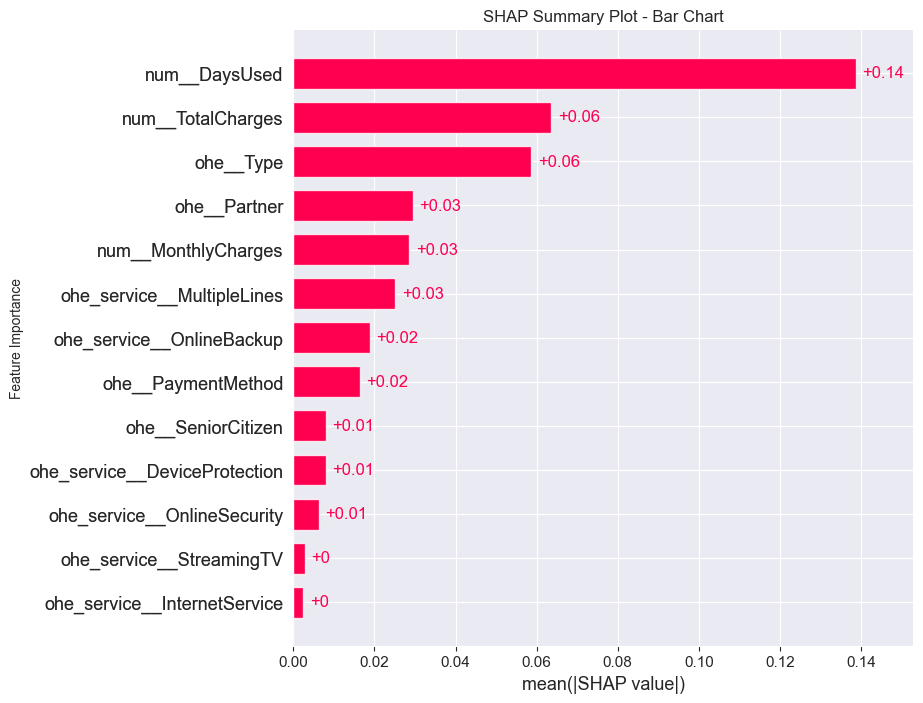

In [70]:
plt.title('SHAP Summary Plot - Bar Chart')
plt.ylabel('Feature Importance')
shap.plots.bar(shap_values, max_display=len(features_ok))
plt.show()

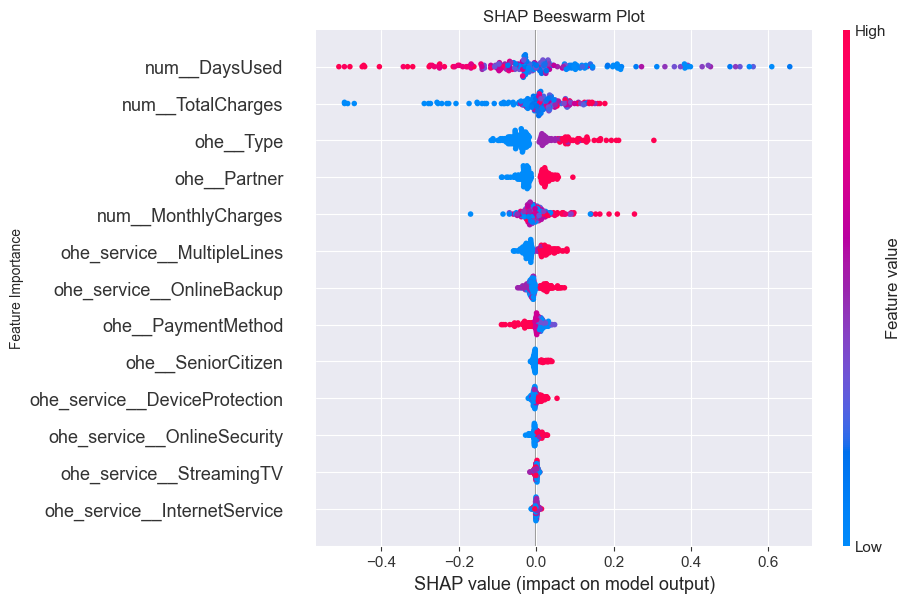

In [71]:
plt.title('SHAP Beeswarm Plot')
plt.ylabel('Feature Importance')
shap.plots.beeswarm(shap_values, max_display=22)
plt.show()

The most important indicators were the number of days of service use, total payments, and whether internet security and cloud storage were enabled (if not enabled, the customer is more likely to churn).

The following factors do not affect churn:
- Internet
- Use of multiple phone lines
- Payment method

# Conclusion

The following steps were completed:

1. Data preprocessing.
Binary attributes were standardized, and missing data was removed, as there was no need to analyze new customers.
2. Exploratory data analysis.
Attribute distributions were identified for both churned and retained customers, as well as attributes for which the distribution was the same.
3. Data preparation.
Strategies for handling missing data were selected, and categorical variables were encoded using one-hot encoding. Different scaling methods were applied for numeric attributes.
4. Model training.
LogisticRegression, RandomForestClassifier, and XGBClassifier were selected as the models. XGBClassifier demonstrated the best results, with a roc-auc value of 0.89 on the test set.
5. Feature analysis.
The most important features for the model were the number of days of service use and the total amount of payments.

**Recommendations for the company:**

It's worth recommending that clients install antivirus software, as they are more likely to retain this service.

You can also check your cloud storage service, as there's a tendency for clients to leave after installing it. They may be dissatisfied with the service.